In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('airline-passengers.csv',usecols=[1], engine='python')

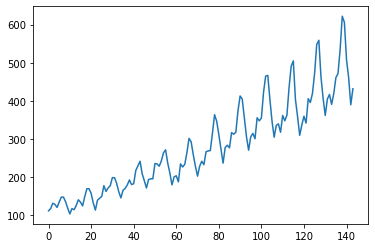

In [3]:
plt.plot(dataset)
plt.show()

# Observations
1.We can see an upward trend in the dataset over time.

2.We can also see some periodicity to the dataset that probably corresponds to the Northern Hemisphere vacation period.

In [4]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
# fix random seed for reproducibility
np.random.seed(7)

In [6]:
dataset = dataset.astype('float32')

In [7]:
#LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used.
#Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.60)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

86 58


In [9]:
#The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, 
#and the look_back, which is the number of previous time steps to use as input variables to predict the next time 
#period — in this case defaulted to 1.

In [10]:
#This default will create a dataset where X is the number of passengers at a given time (t) and 
#Y is the number of passengers at the next time (t + 1).

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# use this function to prepare the train and test datasets for modeling.
#reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
#The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: 
#[samples, time steps, features].
#Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 


In [14]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=65, batch_size=1, verbose=2)

Epoch 1/65
84/84 - 31s - loss: 0.0322
Epoch 2/65
84/84 - 0s - loss: 0.0156
Epoch 3/65
84/84 - 0s - loss: 0.0113
Epoch 4/65
84/84 - 0s - loss: 0.0105
Epoch 5/65
84/84 - 0s - loss: 0.0101
Epoch 6/65
84/84 - 0s - loss: 0.0097
Epoch 7/65
84/84 - 0s - loss: 0.0092
Epoch 8/65
84/84 - 0s - loss: 0.0087
Epoch 9/65
84/84 - 0s - loss: 0.0081
Epoch 10/65
84/84 - 0s - loss: 0.0076
Epoch 11/65
84/84 - 0s - loss: 0.0071
Epoch 12/65
84/84 - 0s - loss: 0.0066
Epoch 13/65
84/84 - 0s - loss: 0.0061
Epoch 14/65
84/84 - 0s - loss: 0.0055
Epoch 15/65
84/84 - 0s - loss: 0.0050
Epoch 16/65
84/84 - 0s - loss: 0.0045
Epoch 17/65
84/84 - 0s - loss: 0.0040
Epoch 18/65
84/84 - 0s - loss: 0.0036
Epoch 19/65
84/84 - 0s - loss: 0.0034
Epoch 20/65
84/84 - 0s - loss: 0.0030
Epoch 21/65
84/84 - 0s - loss: 0.0027
Epoch 22/65
84/84 - 0s - loss: 0.0025
Epoch 23/65
84/84 - 0s - loss: 0.0023
Epoch 24/65
84/84 - 0s - loss: 0.0021
Epoch 25/65
84/84 - 0s - loss: 0.0020
Epoch 26/65
84/84 - 0s - loss: 0.0018
Epoch 27/65
84/84 - 

In [16]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.37 RMSE
Test Score: 46.93 RMSE


In [17]:
#Because of how the dataset was prepared, we must shift the predictionsso that they align on the x-axis with the original dataset.
#Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, 
#and the predictions on the unseen test dataset in red.

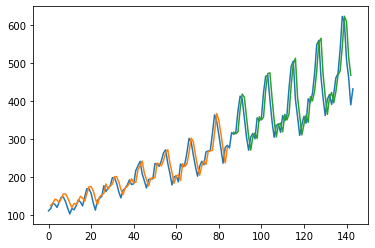

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()